## Treating missing values, winsorizing outliers and feature normalization

In [3]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter


# loading packages
import numpy as np
import pandas as pd


# data visualization and missing values
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
sns.set()
import missingno as msno # missing values
%matplotlib inline

# stats
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import mean_squared_error, r2_score

## I. Explanatory data analysis

- Explore the data, analyse and handle missing values further continuing with quick correlation analysis.

- We conduct a large-scale empirical analysis, investigating nearly 2,660 individual stocks over 24 years from 01.1995 to 12.2020.

- Our predictor set includes 153 characteristics for each stock and 370 industry sector dummy variables, totaling more than 900 baseline signals. Some of our methods expand this predictor set much further by including nonlinear transformations and interactions of the baseline signals.

In [4]:
df = pd.read_csv(r"C:\Users\Besitzer\Documents\Data\ger_factor_data_win_norm.csv", dtype ={"comp_tpci": str})
df["date"] = pd.to_datetime(df["date"], utc = False)  #convert to date format
df["eom"] = pd.to_datetime(df["eom"], utc = False)    #convert to date format
df["sic"] = df["sic"].astype("int")
df[df.columns[11:]] = df[df.columns[11:]].astype('float32')

# sorting with 'date' value
df = df.sort_values(by = ['eom', 'id'], ascending = True) 
# The observation period contains 288 months in the period from 01.1997 to 12.2020'
df.head().append(df.tail(5))

,id,date,eom,size_grp,primary_sec,curcd,fx,common,comp_tpci,comp_exchg,...,ni_be,ocf_at,ocf_at_chg1,mispricing_perf,mispricing_mgmt,qmj,qmj_prof,qmj_growth,qmj_safety,ret_exc_l1
3149,comp_010787_02W,1997-01-31,1997-01-31,mega,0,EUR,1.196431,1,0,154,...,0.880084,0.746053,0.466504,0.554820,0.563529,0.490457,0.519713,0.486312,0.481382,0.369929
3557,comp_011217_05W,1997-01-31,1997-01-31,mega,0,DEM,0.610616,1,0,163,...,0.897216,0.705521,0.443788,0.554820,0.563529,0.490457,0.519713,0.486312,0.481382,0.472879
6996,comp_015334_02W,1997-01-31,1997-01-31,mega,0,DEM,0.610616,1,0,154,...,0.887669,0.766763,0.451614,0.554820,0.563529,0.490457,0.519713,0.486312,0.481382,0.441429
7387,comp_015496_01W,1997-01-31,1997-01-31,small,0,DEM,0.610616,1,0,154,...,0.868083,0.666813,0.482004,0.554820,0.563529,0.490457,0.519713,0.486312,0.481382,0.475827
7591,comp_015496_02W,1997-01-31,1997-01-31,large,1,DEM,0.610616,1,0,154,...,0.868083,0.666813,0.482004,0.554820,0.593921,0.464490,0.358694,0.455148,0.682559,0.387555
302581,comp_333391_05W,2020-12-30,2020-12-31,nano,0,EUR,1.228850,1,0,154,...,0.788653,0.529145,1.000000,0.522787,0.587657,0.507134,0.508439,0.514084,0.517688,NaN
302599,comp_333885_01W,2020-12-30,2020-12-31,large,1,EUR,1.228850,1,0,171,...,0.986769,0.838933,0.550336,0.714599,0.408062,0.507134,0.983899,0.514084,0.362464,NaN
302613,comp_334036_02W,2020-12-30,2020-12-31,nano,0,EUR,1.228850,1,0,154,...,0.555512,0.328884,0.539064,0.522787,0.587657,0.507134,0.508439,0.514084,0.517688,NaN
302618,comp_334302_02W,2020-12-30,2020-12-31,micro,0,EUR,1.228850,1,0,257,...,0.901922,0.730952,0.381399,0.522787,0.587657,0.507134,0.508439,0.514084,0.517688,NaN
302639,comp_336873_02W,2020-12-30,2020-12-31,nano,0,EUR,1.228850,1,0,154,...,0.859403,0.317220,0.069705,0.522787,0.587657,0.507134,0.508439,0.514084,0.517688,NaN


In [28]:
# The observation period contains 288 months in the period from 01.1997 to 12.2020'
df.head(5).append(df.tail(5))

,id,date,eom,size_grp,primary_sec,curcd,fx,common,comp_tpci,comp_exchg,sic,shares,me_company,prc_local,dolvol,ret,ret_local,ret_exc,ret_lag_dif,ret_exc_lead1m,enterprise_value,book_equity,assets,sales,net_income,bidask,prc_high,prc_low,tvol,niq_su,ret_6_1,ret_12_1,saleq_su,tax_gr1a,ni_inc8q,prc_highprc_252d,resff3_6_1,resff3_12_1,be_me,debt_me,at_me,ret_60_12,ni_me,fcf_me,div12m_me,eqpo_me,eqnpo_me,sale_gr3,sale_gr1,ebitda_mev,sale_me,ocf_me,intrinsic_value,bev_mev,netdebt_me,eq_dur,capex_abn,at_gr1,ppeinv_gr1a,noa_at,noa_gr1a,lnoa_gr1a,capx_gr1,capx_gr2,capx_gr3,chcsho_12m,eqnpo_12m,debt_gr3,inv_gr1,inv_gr1a,oaccruals_at,taccruals_at,cowc_gr1a,coa_gr1a,col_gr1a,nncoa_gr1a,ncoa_gr1a,ncol_gr1a,nfna_gr1a,sti_gr1a,lti_gr1a,fnl_gr1a,be_gr1a,oaccruals_ni,taccruals_ni,netis_at,eqnetis_at,dbnetis_at,niq_be,niq_be_chg1,niq_at,niq_at_chg1,ebit_bev,ebit_sale,sale_bev,at_turnover,gp_at,gp_atl1,ope_be,ope_bel1,op_at,op_atl1,cop_at,cop_atl1,f_score,o_score,z_score,pi_nix,at_be,saleq_gr1,rd_me,rd_sale,opex_at,emp_gr1,rd5_at,age,dsale_dinv,dsale_drec,dgp_dsale,dsale_dsga,sale_emp_gr1,tangibility,kz_index,ocfq_saleq_std,cash_at,ni_ar1,ni_ivol,earnings_variability,aliq_at,aliq_mat,seas_1_1an,seas_1_1na,seas_2_5an,seas_2_5na,market_equity,ivol_ff3_21d,ivol_capm_252d,ivol_capm_21d,rvol_21d,beta_60m,betabab_1260d,beta_dimson_21d,turnover_126d,turnover_var_126d,dolvol_126d,dolvol_var_126d,prc,ami_126d,zero_trades_21d,zero_trades_126d,zero_trades_252d,rmax1_21d,rskew_21d,iskew_capm_21d,iskew_ff3_21d,coskew_21d,ret_1_0,betadown_252d,bidaskhl_21d,ret_3_1,ret_9_1,ret_12_7,corr_1260d,rmax5_21d,rmax5_rvol_21d,ni_be,ocf_at,ocf_at_chg1,mispricing_perf,mispricing_mgmt,qmj,qmj_prof,qmj_growth,qmj_safety
0,comp_011217_05W,1995-04-28,1995-04-30,mega,0,DEM,0.723476,1,0,163,3711.0,0.022948,0.057674,0.029758,1.489838e-03,0.566497,0.544687,0.562951,0.0,0.354684,0.044879,0.094307,0.041154,0.203056,0.310965,0.0,0.022418,0.022805,0.000279,0.821289,0.273995,0.244399,0.610439,0.592622,0.625,0.913365,0.509874,0.616631,0.179463,0.046820,0.064955,0.206199,0.946737,0.743146,0.132208,0.091966,0.785859,0.086906,0.245975,0.707313,0.177978,0.643872,0.301486,0.223025,0.103433,0.086119,0.225023,0.163421,0.445109,0.333783,0.203955,0.417988,0.135927,0.140018,0.086831,1.000000,0.000000,0.006211,0.195657,0.608416,0.666385,0.724706,0.524777,0.669635,0.674442,0.486936,0.479288,0.521336,0.636889,0.586425,0.821990,0.490686,0.647019,0.780418,0.718313,0.190246,0.089303,0.457501,0.757579,0.816526,0.755175,0.670705,0.705201,0.948875,0.099585,0.329695,0.135333,0.127728,0.629438,0.495865,0.738836,0.648027,0.568186,0.619353,0.714286,0.137488,0.275038,0.095607,0.044284,0.433572,0.302736,0.030649,0.276539,0.527206,0.167911,0.279805,0.782047,0.820124,0.444924,0.578576,0.414578,0.348617,0.984611,0.008877,0.210377,0.191074,0.055873,0.060537,0.238994,0.517958,0.424932,0.470568,0.629263,0.382375,0.057674,0.067463,0.074854,0.069636,0.066952,0.340620,0.296850,0.403889,0.069601,0.193799,0.003060,0.186978,0.023616,0.000122,0.667244,0.686807,0.634622,0.089198,0.590584,0.484948,0.363640,1.000000,0.579109,0.435388,0.007245,0.337038,0.257858,0.341578,0.370188,0.119646,0.493141,0.908408,0.741921,0.516894,0.518193,0.574414,0.504035,0.492124,0.499321,0.507655
1,comp_015334_02W,1995-04-28,1995-04-30,mega,0,DEM,0.723476,1,0,154,2800.0,0.005395,0.082141,0.180128,1.386088e-04,0.464205,0.477239,0.460776,0.0,0.456254,0.066927,0.056707,0.022863,0.124163,0.187813,0.0,0.142707,0.146109,0.000055,0.683001,0.302556,0.266373,0.686738,0.579626,0.625,0.893073,0.587119,0.555232,0.070685,0.017377,0.023602,0.124591,0.888377,0.717958,0.114480,0.223400,0.818569,0.074765,0.234912,0.649101,0.074704,0.608207,0.086192,0.117687,0.105133,0.349257,0.264896,0.196972,0.641624,0.527262,0.358295,0.534686,0.144407,0.115725,0.078694,0.063880,0.816497,0.009571,0.208760,0.646198,0.577306,0.436059,0.554018,0.722468,0.705946,0.679893,0.713940,0.671159,0.355158,0.352372,0.487257,0.592275,0.587708,0.759020,0.661613,0.112750,0.089954,0.361743,0.7575

In [29]:
#There are 2660 unique german stocks
print(df['id'].nunique())

2669


In [30]:
#Inspect variable types
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306411 entries, 0 to 306410
Data columns (total 174 columns):
 #   Column                Dtype         
---  ------                -----         
 0   id                    object        
 1   date                  datetime64[ns]
 2   eom                   datetime64[ns]
 3   size_grp              object        
 4   primary_sec           int64         
 5   curcd                 object        
 6   fx                    float64       
 7   common                int64         
 8   comp_tpci             object        
 9   comp_exchg            int64         
 10  sic                   float64       
 11  shares                float64       
 12  me_company            float64       
 13  prc_local             float64       
 14  dolvol                float64       
 15  ret                   float64       
 16  ret_local             float64       
 17  ret_exc               float64       
 18  ret_lag_dif           float64       
 19  r

In [32]:
##There are 370 unique SIC-codes in the dataset
print(df['sic'].nunique())

370


<AxesSubplot:xlabel='Date'>

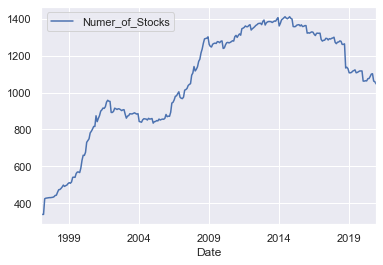

In [8]:
#Number of stocks at each month --> make a graph out of it


Number_stocks_per_month = Counter(df['eom'])
Number_stocks_per_month= pd.DataFrame(Number_stocks_per_month.items(), columns=['Date', 'Numer_of_Stocks'])
Number_stocks_per_month.plot(x='Date', y='Numer_of_Stocks')

In [7]:
Number_stocks_per_month= pd.DataFrame(Number_stocks_per_month.items(), columns=['Date', 'Numer_of_Stocks'])
Number_stocks_per_month

,Date,Numer_of_Stocks
0,1997-01-31,339
1,1997-02-28,339
2,1997-03-31,339
3,1997-04-30,424
4,1997-05-31,427
...,...,...
283,2020-08-31,1100
284,2020-09-30,1102
285,2020-10-31,1062
286,2020-11-30,1059


### Distribution of each feature

In [9]:
features = df.columns[11:174].tolist()


<ipython-input-10-533b9c16d334>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df[features].hist(layout=(28, 6), bins=np.linspace(-1,1,50), ax=ax);


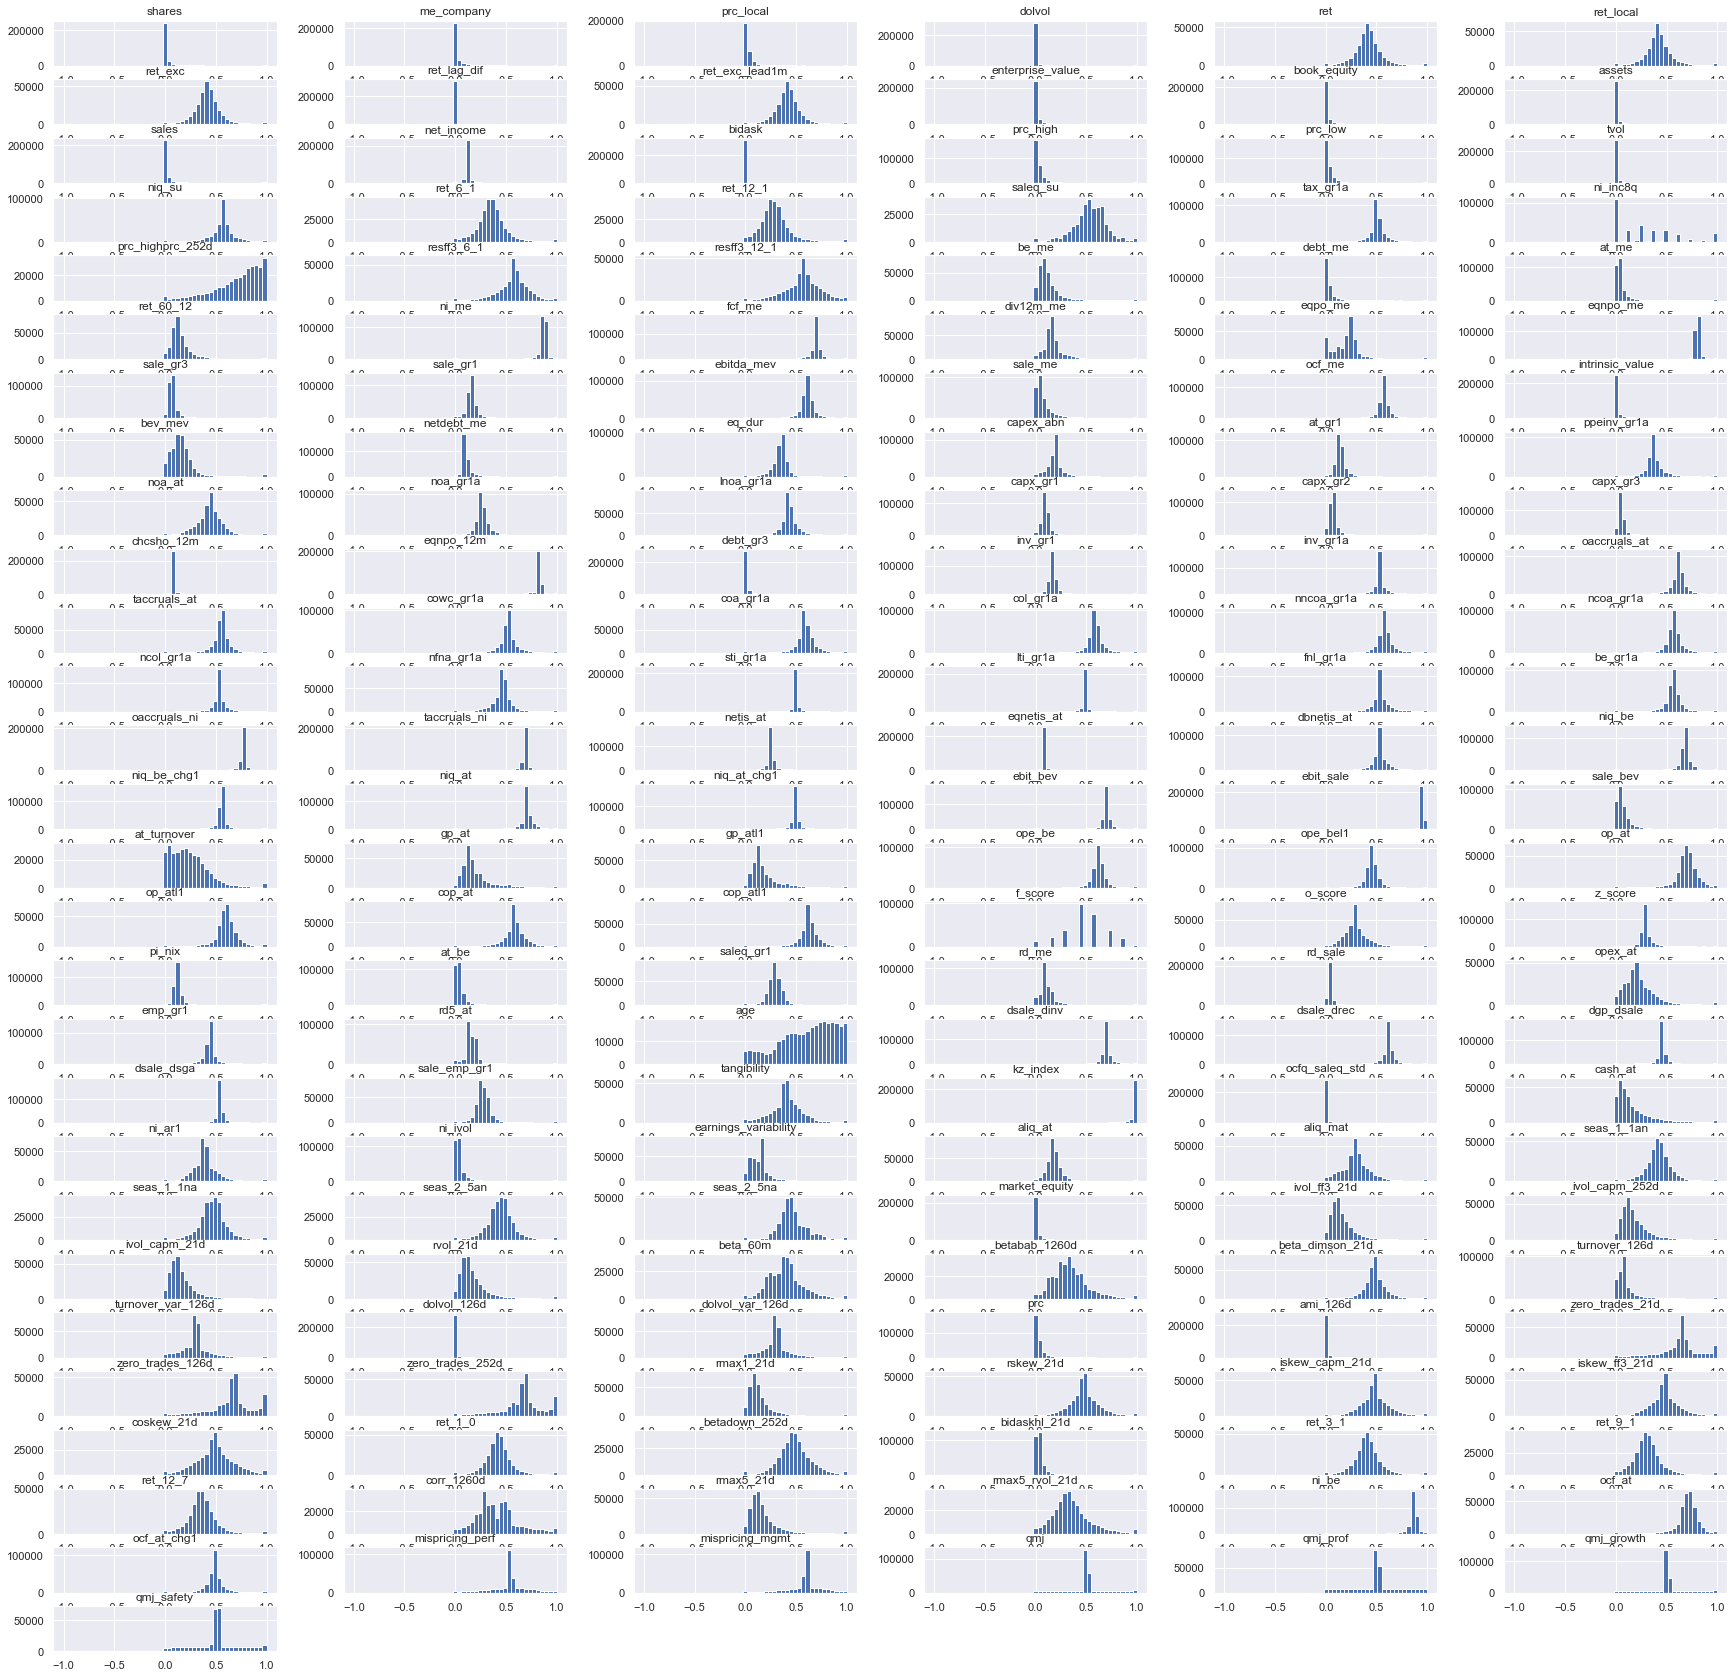

In [10]:
fig, ax = plt.subplots()
fig.set_figheight(30)
fig.set_figwidth(30)
df[features].hist(layout=(28, 6), bins=np.linspace(-1,1,50), ax=ax);

### Correlation of features

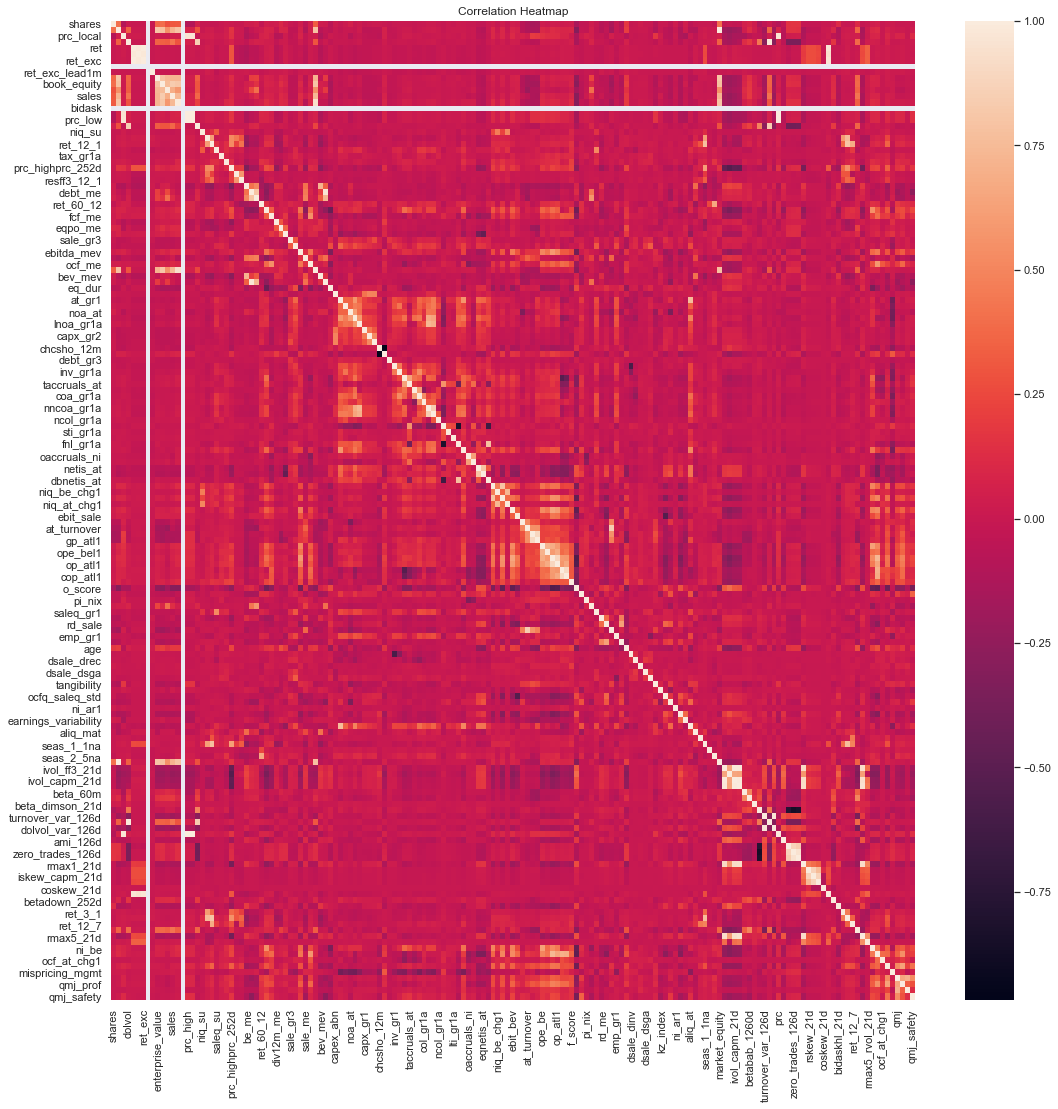

<Figure size 432x288 with 0 Axes>

In [143]:
plt.figure(figsize = (18,18))
sns.heatmap(data=df[features].corr())
plt.title('Correlation Heatmap')
plt.show()
plt.gcf().clear()

### Top Correlated Features

In [11]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
c = df[features].corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort").reset_index()
so.columns = ['col_1','col_2', 'corr']
so = so.sort_values(by = ['corr', 'col_1'], ascending = False)
so = so[so['corr']!=1]
so = so.iloc[::2].reset_index(drop=True)
so

,col_1,col_2,corr
0,ret_exc,ret,0.999937
1,prc_high,prc,0.998575
2,prc_low,prc,0.998225
3,prc_low,prc_high,0.996985
4,ivol_ff3_21d,ivol_capm_21d,0.992265
5,rvol_21d,ivol_capm_21d,0.987127
6,dolvol_126d,dolvol,0.985261
7,ret_local,ret,0.978847
8,ret_local,ret_exc,0.978771
9,rvol_21d,ivol_ff3_21d,0.977712


In [4]:
df = pd.read_csv(r"C:\Users\Besitzer\Documents\Data\ger_factor_data_win_norm.csv", dtype ={"comp_tpci": str}, parse_dates =["eom"])
df["date"] = pd.to_datetime(df["date"], utc = False)  #convert to date format

df["sic"] = df["sic"].astype("int")
df[df.columns[11:]] = df[df.columns[11:]].astype('float32')

# sorting with 'date' value
df = df.sort_values(by = ['eom', 'id'], ascending = True) 
df.head()

,id,date,eom,size_grp,primary_sec,curcd,fx,common,comp_tpci,comp_exchg,...,ni_be,ocf_at,ocf_at_chg1,mispricing_perf,mispricing_mgmt,qmj,qmj_prof,qmj_growth,qmj_safety,ret_exc_l1
3149,comp_010787_02W,1997-01-31,1997-01-31,mega,0,EUR,1.196431,1,0,154,...,0.880084,0.746053,0.466504,0.55482,0.563529,0.490457,0.519713,0.486312,0.481382,0.369929
3557,comp_011217_05W,1997-01-31,1997-01-31,mega,0,DEM,0.610616,1,0,163,...,0.897216,0.705521,0.443788,0.55482,0.563529,0.490457,0.519713,0.486312,0.481382,0.472879
6996,comp_015334_02W,1997-01-31,1997-01-31,mega,0,DEM,0.610616,1,0,154,...,0.887669,0.766763,0.451614,0.55482,0.563529,0.490457,0.519713,0.486312,0.481382,0.441429
7387,comp_015496_01W,1997-01-31,1997-01-31,small,0,DEM,0.610616,1,0,154,...,0.868083,0.666813,0.482004,0.55482,0.563529,0.490457,0.519713,0.486312,0.481382,0.475827
7591,comp_015496_02W,1997-01-31,1997-01-31,large,1,DEM,0.610616,1,0,154,...,0.868083,0.666813,0.482004,0.55482,0.593921,0.464490,0.358694,0.455148,0.682559,0.387555


### How are the features correlated to the dependend variable 

Dependent variable: ret_exc_l1 

In [5]:
corr_matrix = df.corr()
print(corr_matrix["ret_exc_l1"].sort_values(ascending=False))

ret_exc_l1         1.000000
ret_exc_lead1m     0.993398
ret_6_1            0.042318
mispricing_perf    0.038554
eqnpo_me           0.034067
                     ...   
at_gr1            -0.044799
netis_at          -0.047224
noa_gr1a          -0.047664
ret_lag_dif             NaN
bidask                  NaN
Name: ret_exc_l1, Length: 169, dtype: float64


In [14]:
corr_matrix = df.corr()
print(corr_matrix["ret_exc"].sort_values(ascending=False))

ret_exc                 1.000000
ret                     0.999937
ret_local               0.978771
ret_1_0                 0.968412
rmax5_rvol_21d          0.341382
prc_highprc_252d        0.299685
rskew_21d               0.265036
iskew_capm_21d          0.264127
rmax5_21d               0.258022
seas_1_1na              0.255345
iskew_ff3_21d           0.235760
rmax1_21d               0.195070
fcf_me                  0.049822
ivol_ff3_21d            0.047579
ivol_capm_21d           0.043673
ret_6_1                 0.041494
eqnpo_me                0.040116
ni_me                   0.038680
fx                      0.035388
ret_9_1                 0.034864
age                     0.033693
mispricing_perf         0.032923
cop_at                  0.032368
rvol_21d                0.032181
ocf_at                  0.031278
qmj_prof                0.029921
cop_atl1                0.028152
prc                     0.027085
f_score                 0.026519
ret_12_1                0.025555
beta_60m  

### Spearman corellation

In [24]:
features1 = df.columns[33:41].tolist()

In [20]:
from scipy.stats import spearmanr
spearman = {}
for feature in features:
    x1 = df[feature]
    x2 = df['ret_exc'].values
    bad = ~np.logical_or(np.isnan(x1), np.isnan(x2))
    score = spearmanr(np.compress(bad, x1), np.compress(bad, x2))[0]
    spearman[feature] = score
spearman = pd.Series(spearman)

C:\Users\Besitzer\anaconda3\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [21]:
spearman.apply(np.abs).sort_values(ascending=False) * spearman.apply(np.sign)[spearman.apply(np.abs).sort_values(ascending=False).index]

ret_exc                 1.000000
ret                     0.999854
ret_1_0                 0.973356
ret_local               0.955980
prc_highprc_252d        0.375016
rmax5_rvol_21d          0.346039
seas_1_1na              0.248697
iskew_capm_21d          0.247017
rskew_21d               0.245289
iskew_ff3_21d           0.220584
rmax5_21d               0.207071
rmax1_21d               0.141865
be_me                  -0.099685
prc                     0.095830
div12m_me              -0.091424
prc_local               0.089284
bev_mev                -0.088866
me_company              0.087622
market_equity           0.087622
at_me                  -0.079383
resff3_12_1            -0.072964
prc_low                 0.071729
bidaskhl_21d           -0.069766
enterprise_value        0.069049
prc_high                0.067743
netis_at               -0.062880
ocf_at                  0.062454
resff3_6_1             -0.060056
eqnetis_at             -0.059283
net_income              0.056423
ivol_capm_